
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">



# <center> **03. Fundamentals of Machine Learning: Classification** </center>



##  **Outline**
1. [**The classification problem (CP)**](#CP)
2. [**CP from linear hypothesis: Logistic regression (LR)**](#LR)
3. [**A new loss function: The cross-entropy**](#CE)
4. [**Gradient descent for LR**](#Grad_LR)





In [ ]:
#@title **Execute this cell**
#@markdown Please include your student id
import sys
import inspect

group_id = "IA2-20231-H1" #@param {type:"string"}
assignment_id = group_id +'.dl_classif'
student_id = "2218109" #@param {type:"string"}
"""
Put your student ID here

Example: student_id =  '2152145'
"""

"\nPut your student ID here\n\nExample: student_id =  '2152145'\n"

In [ ]:
#@title **Execute this cell**
#@markdown **UTILS**
#@markdown Please dont modify any line in this cell

import os
import json
import requests
from collections import namedtuple


Config = namedtuple('Config', ['server_name'])
config = Config(server_name='https://bivlabgrader.azurewebsites.net/api')


def check_solution_and_evaluate(assignment_id: str, student_func_str: str):

    # Set the endpoint and payload.
    payload = {
        'func_str': student_func_str,
        'assignment_id': assignment_id,
        'student_id': student_id
    }
    endpoint_url = config.server_name + '/CheckAndEvaluateSolution'
    # print(endpoint_url)

    # Make request to server with the data coming from the notebook.
    r = requests.post(endpoint_url, params=payload)
    pprint_json_response(r.json())
    return r


def pprint_json_response(response, indent=0):
    """Pretty print the response."""
    for key, value in response.items():
        print('\t' * indent + str(key.capitalize()))

        # If dictionary, do a recurrent call.
        if isinstance(value, dict):
            pprint_json_response(value, indent + 1)
        else:
            # Enumerate elements if list.
            if isinstance(value, list):
                if len(value) == 1:
                    print('\t' * (indent + 1) + str(value[0]))
                else:
                    for i, e in enumerate(value, start=1):
                        print('\t' * (indent + 1) + f'{i}. {e}')
            else:
                print('\t' * (indent + 1) + str(value))

In [ ]:
#@title **Student:** Mount the Drive  (If you are in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/course-IA2/ai-2-uis-student')
os.chdir('/content/drive/MyDrive/UIS/Courses/2020-UIS-MachineAnsDeepLearning/ai-2-uis-student')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1NGefTk7hA8tb7ARun-C3IwOn2dGOcicJ/ai-2-uis-student


In [ ]:
#@title **Import libraries**
import io
import time
import requests
%matplotlib inline
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt

# 1. **The classification problem (CP)** <a name="CP"> </a>

In clasification problem we try to **find** boundaries that separate classes *(labels)* $\mathbf{Y}$ given a set of *features* $\mathbf{X}$.

The most common is the binary classification problem. Labels only can take the values $y = \{0, 1\}$. From a lineal hypothesis, the **boundaries** represents a *threshold* that deppends on the feature dimensionality. It could be a number, a line, a plane, or even a hyperplane

Examples:
- **Emails:** Spam**(1)**/Not spam**(0)**
- Cancer**(1)**/Not cancer**(0)**
- Parkinson**(1)**/Not Parkinson**(0)**

Multiclassification problems, it is defined by labels with $y = \{0,1,2,\ldots \}$

But... how can we "use" a linear regression into classification problems?

<center><img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/linearvsLogistic.png" width="800"></center>


# **2. CP from a linear hypothesis: Logistic regression (LR)** <a name="LR"> </a>
Based on the linear regression formulation, we can formulate the problem to find a line, plane or hyper-plane that **separates** different kinds of elements! What we should have?

- **We then need to transform linear output in a probability.**

- **Hypothesis: representation**

Let's consider two groups of elements (like the one generated by `make_blobs`). For **classification**, the variable $y$ should take values of 0 or 1.

 Then, we should envolve *linear regression function* with sigmoid function $g$, as:
$$\hat{y} = f_{\omega}(z) = g(\underset{z}{\underbrace{\omega_0 + \omega_1 x + \epsilon}})$$

This sigmoid or logistic function $f_{\omega}(z)$, with $z = \omega_0+\omega_1x$,  is defined as:

| | |
|:-------------------------:|:-------------------------:|
|$$\LARGE g = \frac{1}{1+e^{-z}}$$ |  <center><img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/logistic_transformation.png" width="400"></center>|

The interpretation of $f_{\omega}(z) $ can be done by probability of predict $y=1$ if $f_{\omega}(z) \geq 0.5$, defined as:

$$\hat{y} = f_{\omega}(z) = P(y=1|z;\omega)$$

and then :

**(b)** $P(y=0|z;\omega) = 1 - P(y=1|z;\omega)$.

Also, note that:

- $g(z) \geq 0.5$ when $z \geq 0$
- So,  $(\omega_0 + \omega_1 x) \geq 0$
- $\hat{y}=1$ when  $(\omega_0 + \omega_1 x) \geq 0$

According to _ODDS ratio_ there exist a **linear asociation** that $P(y=1|z;\omega)$ ocurrs regarding $P(y=0|z;\omega)$

# **3. A new loss function: The cross-entropy** <a name="CE"> </a>

### **3.1 Some considerations**
- The output of $\hat{y} = f_{\omega}(x)$ can be interpreted as a probability $P(y=1|z;\omega)$
- Because we limit our problem to binary classification $y=\{0,1\}$, we have a dicrete binary distribution.
- So, we can aproximate to a Bernoulli distribution, from **b**. Then, we can write:
$$P(y|\ z;\omega) = {\left[P(y=1|z;\omega)\right]}^{y}{\left[1-P(y=1|z;\omega)\right]}^{1-y}$$

* This way, **when $y=1$** we have $P(y|z;w) = P(y=1|z;\omega)$.
* And **when $y=0$** we have $P(y|z;w) = 1- P(y=1|z;\omega)$.


### **3.2 Maximum likelihood**

The output probability can be seen as a function depending of $z,\omega$. If we wish to view that as a function of $w$ we call it **likelihood**.

Because the independence asumption, we have:

\begin{align}
L(w) &= \prod_{i=1}^{n} P(y_i | z_i; \omega)\nonumber \\
  &= \prod_{i=1}^{n} {\left[P(y_i=1|z_i;\omega)\right]}^{y_i}{\left[1-P(y_i=1|z_i;\omega)\right]}^{1-y_i} \\
  &= \prod_{i=1}^{n} {g(z_i)}^{y_i}(1-g(z_i))^{1-y_i} \\
  &= \prod_{i=1}^{n} \hat{y_i}^{y_i} (1-\hat{y_i}^{y_i})
\end{align}

Remember that we have a Bernoulli consideration. We can use the log-likelihood, because  logarithmic function is a monotone increasing function. If we apply logarithm ($\log{(m^n)} = n\log{m}$), we obtain:

\begin{align}
J(w) &= \log J(w) \\
  &=  \sum_{i=1}^{n} y_{i}\log(P(y_i=1|z_i;\omega)) + (1-y_{i})\log(1-P(y_i=1|z_i;\omega)) \\
  &= \sum_{i=1}^{n} y_{i}\log(\hat{y_i}) + (1-y_i)\log(1-\hat{y_i})
\end{align}


**THIS IS MY NEW COST FUNCTION RULE!!!**

This function is known as the **log-likelihood** and is our error or loss function. Minimizing the **negative** log likelihood corresponds to maximizing the likelihood.

With this function we want to find the parameters that **maximize** the log-likelihood function or what is equivalent to **minimize** the function to find the parameters that generate the least error possible  for our entire sample set.

$$J(\omega) = -\frac{1}{n}\sum_{i=1}^{n} y_{i}\log(\hat{y_i}) + (1-y_i)\log(1-\hat{y_i})$$


**A CROSS ENTROPY FOR A BINARY PROBLEM**

- **For logistic regression, this function is CONVEX!**
This is an example, and know, we will to construct our logistic regression

/content/drive/.shortcut-targets-by-id/1NGefTk7hA8tb7ARun-C3IwOn2dGOcicJ/ai-2-uis-student/code/plot_class_1_2.py:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(io.StringIO(s.decode('utf-8')),error_bad_lines=False, header=None, usecols=[0,4,5,7], names=['Specie', 'Elongation', 'Convexity', 'Circularity'] )


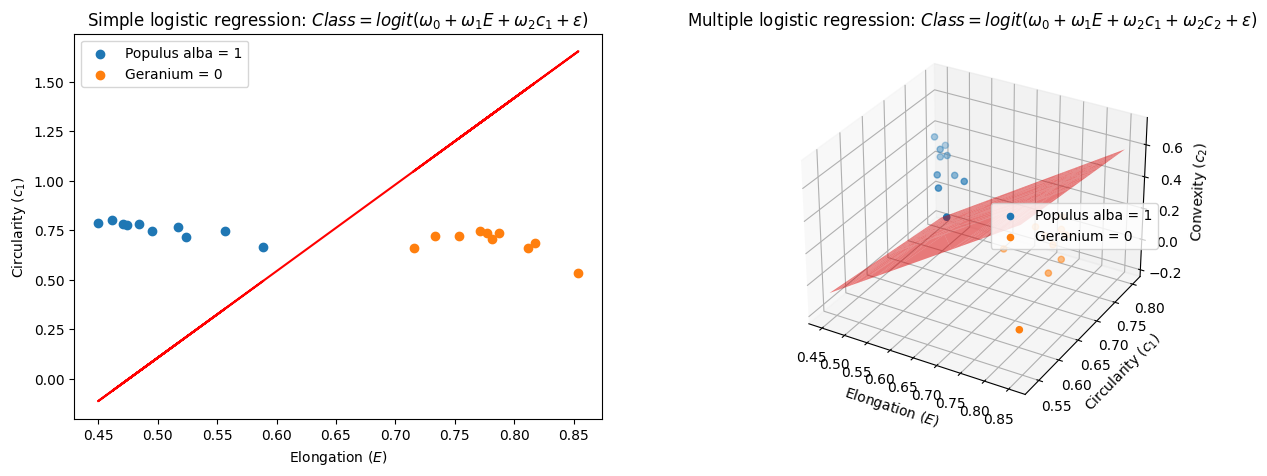

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Logistic regression plots { display-mode: "form" }
%run -i 'code/plot_class_1_2.py'

# **4. Gradient descent for LR** <a name="Grad_LR"> </a>

The algorithm is the same, we just need to define the cost, and gradient of the cost. The we can operate the gradient descent

### **Cost function**
The log likelihood rule, can we written as:
$$
J(\omega) = \left\{\begin{matrix}
- \log(\hat{f_{\omega}(x)}) &\text{if} & y=1\\
- \log(1-\hat{f_{\omega}(x)}) &\text{if} & y=0
\end{matrix}\right.$$

This define our cost function:
$$J(\omega) = -\frac{1}{n}\sum_{i=1}^{n}y_{i}\log(\hat{y}) + (1-y_{i})\log(1-\hat{y})$$


Go to the action!

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- We will work with an artifitial dataset for classification. Please load and explain how to use the next functions in `sklearn`:


```
make_classification
```
and
```
make_blobs
```
- Use two classes and two features. Also a total of 1000 samples.  Plot the results wit labels for each class.

- How works linear regression in classification task?



In [ ]:
#@title **Student code for the solution**
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification

np.random.seed(1)
X1, Y1 = ...
X2, Y2 = ...

print(X1.shape, Y1.shape)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, s=25)
ax = fig.add_subplot(1, 3, 2)
ax.set_ylabel('X_0');ax.set_xlabel('X_1')
ax.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2, s=25)
ax = fig.add_subplot(1, 3, 3)
ax.set_ylabel('X_0'); ax.set_xlabel('X_1')
ax.scatter(X2[:, 0], Y2, marker='o', c=Y2, s=25)
ax.set_ylabel('Y');ax.set_xlabel('X_0')

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Implement the cost function

Remember that the calculation of $\hat{y}$ is done through the **linear** and **sigmoid** function.

In [ ]:
#@title **Coding:** Sigmoid, linear, and prob functions
def sigmoid(x):
    # Activation function used to map any real value between 0 and 1
    return 1 / (1 + np.exp(-x))

def linear(w, x):
    # Computes the weighted sum of inputs
    n = x.shape[0]
    return (1 / n) * np.dot(x, w.T)

def prob(linear):
    # Returns the probability after passing through sigmoid
    return sigmoid(linear)

In [ ]:
#@title **Student code for the solution** Cost function implementation
def cost_function(w, x, y):
  def sigmoid(x):
    #Import libraries
    import numpy as np
    """
    Put your code here
    """

  def linear(w, x):
    #Import libraries
    import numpy as np
    """
    Put your code here
    """

  def prob(linear):
    """
    Put your code here
    """

  #Import libraries
  import numpy as np
  # Computes the cost function for all the training samples
  n = x.shape[0]
  linear_value = ....
  probabilities = .....
  total_cost =  ...
  return total_cost

# evaluated on blobs dataset
beta = np.zeros(2).reshape(1, 2)
cost_function(w, X2, Y2)

In [ ]:
 #@title ## **Send your answer**
student_func_str = inspect.getsource(cost_function)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Score
	5
Message
	Well done. You got the highest score.
Status
	You have achieved your best score: 5


### Gradient of $J(\omega)$

$$\frac{\partial J(\omega)}{\partial \omega_j}=\frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_{i})x_{i}^{j}$$

Or equivalently in a matrix notation:

$$\frac{\partial J(\omega)}{\partial \omega}=\frac{1}{n}X^T(\hat{Y}-Y)$$

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Implement this gradient function

In [ ]:
#@title **Student code for the solution** Gradient of $J$ cost function implementation
def gradient(prob, x, y):
  # Computes the gradient of the cost function at the point theta
  """
  Put your code here
  """
  return dev_J

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

The function should calculates the predictions ($\hat{y}$) and computes the gradient ($\nabla J(\omega)$).

In [ ]:
#@title **Coding** gradient over probability
def cost_gradient(x, y, w):
  """
  Put your code here
  """
  return gradient(probabilities, x, y)

### Gradient descent algorithm computation

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Complete implementation

In [ ]:
#@title **Student code for the solution** Gradient descent

def grad_des_ew(X, Y, beta_0, beta_1, beta_2, learning_rate, batch):
  def sigmoid(x):
    #Import libraries
    import numpy as np
    """
    Put your code here
    """

  def linear(w, x):
    #Import libraries
    import numpy as np
    """
    Put your code here
    """

  def prob(linear):
    """
    Put your code here
    """

  def gradient(prob, x, y):
    #Import libraries
    import numpy as np
    """
    Put your code here
    """

  def cost_gradient(x, y, w):
    """
    Put your code here
    """

  def cost_function(w, x, y):
    #Import libraries
    import numpy as np
    """
    Put your code here
    """

  #Import libraries
  import numpy as np
  costs = []
  beta = np.array([beta_0,beta_1, beta_2])
  for i in range(batch):
    print(f"it ({i}/{batch}) | Cost: {cost_function(beta, X, Y):0.05f}")
    costs.append(cost_function(beta, X, Y))
    dlldbeta = ...
    beta_new = ...
    if i > batch or np.sum(np.abs(beta - beta_new))<0.00001:
      print(f"At ITERATION {i}, Diff cost: {np.sum(np.abs(beta - beta_new))}")
      break
    beta = beta_new

  return beta, costs


X_pon =  np.concatenate((np.ones(X2.shape[0]).reshape(X2.shape[0], 1), X2), axis=1) #Adding a column with 1s
w, costs = grad_des_ew(X_pon, Y2, 18, -10, 11,  0.9, 500)
print(w)
print(w.shape)

In [ ]:
 #@title ## **Send your answer**
student_func_str = inspect.getsource(grad_des_ew)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Score
	5
Message
	Well done. You got the highest score.
Status
	You have achieved your best score: 5


<ipython-input-8-8e6b7853528d>:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


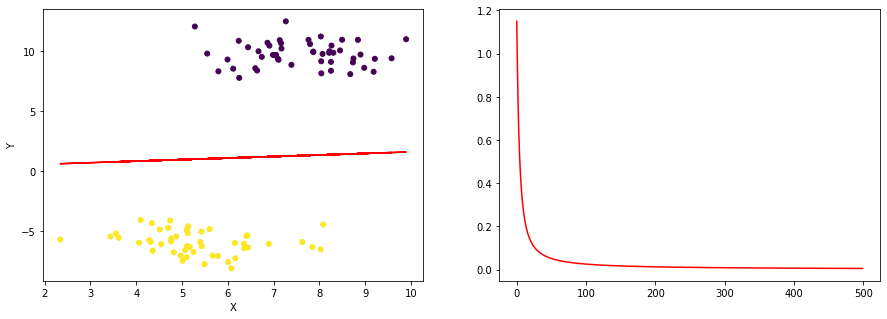

In [ ]:
#@title **Coding** Plot your results!
x2_est= (-(w[1]*X2[:, 0]) - w[0]) /w[2]
y_class = w[0] + w[1]*X2[:, 0]+ w[2]*X2[:, 1]
y_c = sigmoid(y_class)*1

fig = plt.figure(figsize=(15,5))
#The linear separation between classes
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X2[:, 0], X2[:, 1], marker='o', c=y_c, s=25)
ax.plot(X2[:, 0] , x2_est, c="red")
ax.set_xlabel('X')
ax.set_ylabel('Y')
#Costs among batch
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(len(costs)) , costs, c="red")


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Now, we will to work with **[Leaf dataset](https://archive.ics.uci.edu/ml/datasets/Leaf)**.

- What about this dataset?
- Load the dataset with pandas (`data/leaf_class_1.csv`) and use:
  - Geometrical features of leafs in this case: Specie, Elongation, Convexity, Circularity

- We only will take two classes: Geranium (Specie==36), Populus_alba (Specie==15)
  - Take defined features $(\mathbf{X})$ of only two defined clases
  - Define a $(\mathbf{Y})$ vector with Geranium==0 and Populus_alba==1

In [ ]:
#@title **code** Loading leaf dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_leaf = pd.read_csv('https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/data/leaf_class_1.csv',error_bad_lines=False,
                        header=None, usecols=[0,4,5,7], names=['Specie', 'Elongation', 'Convexity', 'Circularity'] )
data_leaf.head()

<ipython-input-37-7e5140d2184b>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data_leaf = pd.read_csv('https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/data/leaf_class_1.csv',error_bad_lines=False,


Specie  Elongation  Convexity  Circularity
0       1     0.32396    0.98535      0.83592
1       1     0.36116    0.98152      0.79867
2       1     0.38998    0.97755      0.80812
3       1     0.35376    0.97566      0.81697
4       1     0.44462    0.97698      0.75493

In [ ]:
#@title **Student code for the solution**
# Select the features for each type of leaf
Geranium = ....
Populus_alba = ....
# Indicate the classification variable
Y = ....
# Concatenate to form the training data
X = np.vstack([Geranium, Populus_alba])
X = np.concatenate([np.ones(shape=(Y.shape[0],1)), X], axis=1)

In [ ]:
#@title **code student** Run Gradient Descent
def gradient_descent_method(learning_rate, iterations):
    # Parameters
    i = 0
    iterations = iterations
    learning_rate = learning_rate
    # STEP 1
    # Definition and initialization of the coefficients beta
    b0 = np.zeros(3).reshape(1, 3)
    beta = b0
    # To store the cost value in each iteration
    costs = []

    while True:
        # Cost computation
        costs.append(cost_function(beta, X, Y))
        # STEP 2
        # Gradient computation
        dlldbeta =  ....
        # STEP 3
        # Coefficients updating
        beta_new =  ....
        i += 1
        # STEP 4
        # Calculate error tolerance to stop the algorithm
        # The algorithm stops when it reaches the limit number of iterations
        # or when it has a small error
        if i > iterations or np.sum(np.abs(beta - beta_new))<0.00001:
            break
        beta = beta_new

        # plot the results
        if i% 100 == 0:
            print('Learning rate:{}'.format(learning_rate))
            print('Iteration: {} of {}'.format(i, iterations))
            plot_gradient_descent_step(X, beta, costs, Populus_alba, Geranium, iterations)
            display.clear_output(wait=True)
            time.sleep(0.1)

In [ ]:
#@title Gradient Descent plot { display-mode: "form" }
def plot_gradient_descent_step(X, beta, costs, Populus_alba, Geranium, iterations):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.set_title('Cost vs iteration');
    ax1.set_xlabel('Iteration');
    ax1.set_ylabel('Cost');
    ax1.plot(costs);
    ax1.set_xlim([0, iterations]);
    ax1.set_ylim([0, 1]);
    ax2.scatter(Populus_alba[:, 0], Populus_alba[:, 1], label='Populus alba = 1');
    ax2.scatter(Geranium[:, 0], Geranium[:, 1], label='Geranium = 0');
    y = (-(beta[0][1]*X[:,1]) - beta[0][0]) /beta[0][2]
    ax2.plot(X[:,1],y, c='r');
    ax2.set_ylim([-0.25, 1]);
    ax2.set_title('Boundary');
    ax2.set_xlabel(r'Elongation ($E$)');
    ax2.set_ylabel(r'Circularity ($c_1$)');
    plt.legend();
    plt.show()

def gradient_descent_plot():
    import ipywidgets as widgets
    from ipywidgets import interact
    import matplotlib.pyplot as plt
    import numpy as np
    values=[1/pow(10,j) for j in range(1, 5)]
    widgets.interact(gradient_descent_method,
                      iterations=widgets.IntSlider(min=1000, max=50000, step=1000, value=20000),
                      learning_rate=widgets.SelectionSlider(options=[("%g"%i,i) for i in values]),
                      )

gradient_descent_plot()

interactive(children=(SelectionSlider(description='learning_rate', options=(('0.1', 0.1), ('0.01', 0.01), ('0.…

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- What about multiclassification problem?
- What about Non linear boundaries?
- Homework: Which is the derivate of sigmoid function?


# References

[1. Introduction to Deep Learning From Logical Calculus to Artificial Intelligence](https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/blob/master/bib/student_2016_Book_IntroductionToStatisticsAndDat.pdf)

[2. Introduction to Data Science A Python Approach to Concepts, Techniques and Applications ](https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/blob/master/bib/student_2017_Book_IntroductionToDataScience.pdf)

[3. Neural network internals](https://becominghuman.ai/neural-network-learning-internals-logistic-regression-8fb086e47867)

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">